Evaluating on alternative worlds

In [85]:
from swdata import (AsymScene, Scene, SWorld, TrainEx, load_components,
                    make_from_components)
import swdata
import numpy as np
from tqdm import tqdm
%matplotlib ipympl


In [5]:
from rnn_syn import CONFIGS, build_end2end_model, RNN_CELLS

In [68]:
train_cf = CONFIGS['shape_color_generalization_5']['train']
test_cf = CONFIGS['shape_color_generalization_5']['test']

In [8]:
import tensorflow as tf

In [9]:
tfs, tls, tfl, tll, t_msg, t_pred, t_loss, convs, convl = build_end2end_model(
                5,
                net_arch=(256, 64, 1024),
                discrete=False,
                rnncell=RNN_CELLS['gru'],
                asym=True)

In [10]:
session = tf.Session()

In [11]:
saver = tf.train.Saver()
saver.restore(session, 'saves/pristine5k_all.ckpt')

INFO:tensorflow:Restoring parameters from saves/pristine5k_all.ckpt


In [13]:
configs, components_dict = load_components(train_cf + test_cf)

Load components: 100%|██████████| 253/253 [03:39<00:00,  1.15it/s]


In [128]:
# Initialize graph and keep track of computed config accuracies.
import networkx as nx
G = nx.Graph()
for config in configs:
    G.add_node(config + (1, ))
    G.add_node(config + (-1, ))


In [137]:
all_config_accs = {}
config_perfs = {}

In [ ]:
configs_to_test = [
    (('square', 'red'), ('triangle', 'blue'), 'x-rel'),
    # (('cross', 'magenta'), ('triangle', 'blue'), 'x-rel'),
    (('circle', 'magenta'), ('cross', 'magenta'), 'y-rel'),
    (('triangle', 'cyan'), ('triangle', 'red'), 'x-rel'),
    (('cross', 'blue'), ('triangle', 'blue'), 'y-rel'),
    (('cross', 'green'), ('triangle', 'red'), 'y-rel'),
    (('circle', 'green'), ('triangle', 'cyan'), 'x-rel')
]

for config in configs_to_test:
    if (config + (1, )) in config_perfs and (config + (-1, )) in config_perfs:
        print("Skipping {}".format(config))
        continue
    cfs = [config]
    
    batch, batch_metadata = zip(*make_from_components(32, cfs, components_dict, False,
                     {'max_images': 5, 'min_targets': 2, 'min_distractors': 1},
                    weighted=False))
    rel1, rel1_md = zip(*(t for t in zip(batch, batch_metadata) if t[1]['relation_dir'] == 1))
    rel0, rel0_md = zip(*(t for t in zip(batch, batch_metadata) if
                          t[1]['relation_dir'] == -1))
    
    for ri, rel, rel_md in [(1, rel1, rel1_md), (-1, rel0, rel0_md)]:

        bse, bsl, batch_envs, batch_labels = \
            swdata.prepare_end2end(rel, 5, asym=True)

        # Get target message
        tgt_msg, tgt_pred = session.run(
            [t_msg, t_pred], {
                tfs: np.array([bse[0]]),
                tls: np.array([bsl[0]]),
                tfl: np.array([batch_envs[0]]),
        })
        if not np.all((tgt_pred > 0) == np.array([batch_labels[0]]), axis=1):
            print("tgt not correct, continuing")
            continue

        this_config_accs = {}
        high_perf = set()
        med_perf = set()
        low_perf = set()
        for other_config in tqdm(configs, desc='Evaluating {} {} on alt worlds'.format(config, ri)):
            cfs = [other_config]

            batch, batch_metadata = zip(*make_from_components(32, cfs, components_dict, False,
                                         {'max_images': 5, 'min_targets': 2, 'min_distractors': 1},
                                    weighted=False))
            other_rel1, other_rel1_md = zip(*(t for t in zip(batch, batch_metadata) if t[1]['relation_dir'] == 1))
            other_rel0, other_rel0_md = zip(*(t for t in zip(batch, batch_metadata) if
                                  t[1]['relation_dir'] == -1))

            bse, bsl, batch_envs, batch_labels = \
                swdata.prepare_end2end(other_rel1, 5, asym=True)

            # Repeat the message for the batch
            tgt_rep = np.vstack(tgt_msg for _ in range(batch_envs.shape[0]))

            other_pred = session.run(
                t_pred, {
                t_msg: tgt_rep,
                tfl: batch_envs
            })
            acc = np.all((other_pred > 0) == batch_labels, axis=1).mean()

            this_config_accs[other_config + (1, )] = acc

            if acc_rev >= 0.8:
                high_perf.add(other_config + (1, ))
            elif 0.5 < acc < 0.8:
                med_perf.add(other_config + (1, ))
            else:
                low_perf.add(other_config + (1, ))
            
            # continue


            # Reverse roles
            bse, bsl, batch_envs, batch_labels = \
                swdata.prepare_end2end(other_rel0, 5, asym=True)

            tgt_rep = np.vstack(tgt_msg for _ in range(batch_envs.shape[0]))

            rev_pred = session.run(
                t_pred, {
                t_msg: tgt_rep,
                tfl: batch_envs
            })
            acc_rev = np.all((rev_pred > 0) == batch_labels, axis=1).mean()
            this_config_accs[other_config + (-1, )] = acc_rev

            if acc_rev >= 0.8:
                high_perf.add(other_config + (-1, ))
            elif 0.5 < acc_rev < 0.8:
                med_perf.add(other_config + (-1, ))
            else:
                low_perf.add(other_config + (-1, ))
        
        config_perfs[config + (ri, )] = {
            'high': high_perf,
            'med': med_perf,
            'low': low_perf
        }
        all_config_accs[config + (ri, )] = this_config_accs

In [322]:

SIMILAR_COLORS = {
    'blue': {'blue', 'green', 'cyan'},
    'red': {'red', 'magenta', 'yellow'},
    'green': {'blue', 'green', 'cyan', 'yellow'},
    'cyan': {'blue', 'green', 'cyan'},
    'yellow': {'red', 'yellow'},
    'magenta': {'red', 'magenta'}
}
def similar_configs(reference, other):
    ref_s1, ref_s2, ref_x, ref_reldir = reference
    oth_s1, oth_s2, oth_x, oth_reldir = other
    if samecolor(other):
        return False
    
    # Return on exact matches
    if oth_s1 == ref_s1:
        return ref_reldir == oth_reldir
    if oth_s1 == ref_s2:
        return ref_reldir != oth_reldir
    if oth_s2 == ref_s1:
        return ref_reldir != oth_reldir
    if oth_s2 == ref_s2:
        return ref_reldir == oth_reldir
    
    # Return on same color matches
    if oth_s1[1] == ref_s1[1]:
        return ref_reldir == oth_reldir
    if oth_s1[1] == ref_s2[1]:
        return ref_reldir != oth_reldir
    if oth_s2[1] == ref_s1[1]:
        return ref_reldir != oth_reldir
    if oth_s2[1] == ref_s2[1]:
        return ref_reldir == oth_reldir
    
    # Return on whatever's closest
    maybe_s1, maybe_s2, maybe_s3, maybe_s4 = False, False, False, False
    if oth_s1[1] in SIMILAR_COLORS[ref_s1[1]]:
        maybe_s1 = ref_reldir == oth_reldir

    if oth_s1[1] in SIMILAR_COLORS[ref_s2[1]]:
        maybe_s2 = ref_reldir != oth_reldir

    if oth_s2[1] in SIMILAR_COLORS[ref_s2[1]]:
        maybe_s3 = ref_reldir == oth_reldir

    if oth_s2[1] in SIMILAR_COLORS[ref_s1[1]]:
        maybe_s4 = ref_reldir != oth_reldir
        
    return maybe_s1 or maybe_s2 or maybe_s3 or maybe_s4
def samecolor(cf):
    return cf[0][1] == cf[1][1]

like_unlike_accs = {}
for cf, cf_accs in all_config_accs.items():
    if samecolor(cf):
        continue
    likes = []
    unlikes = []
    for oth_cf, oth_cf_acc in cf_accs.items():
        if oth_cf_acc > 0.5:
            likes.append(oth_cf_acc)
        else:
            unlikes.append(oth_cf_acc)
        continue
        if similar_configs(cf, oth_cf):
            if oth_cf_acc < 0.5:
                print("MISMATCH:", cf, "is like", oth_cf, "acc:", oth_cf_acc)
            likes.append(oth_cf_acc)
        else:
            if oth_cf_acc > 0.5:
                print("MISMATCH:", cf, "is unlike", oth_cf, "acc:", oth_cf_acc)
            unlikes.append(oth_cf_acc)
    print(cf, np.mean(likes), np.mean(unlikes))
    like_unlike_accs[cf] = {'like': np.mean(likes), 'unlikes': np.mean(unlikes)}

(('circle', 'green'), ('triangle', 'cyan'), 'x-rel', 1) 0.8937896784160225 0.01736086135402667
(('square', 'red'), ('triangle', 'blue'), 'x-rel', -1) 0.923396497785848 0.008317630562475335
(('cross', 'green'), ('triangle', 'red'), 'y-rel', -1) 0.8715819325381028 0.018573239102296375
(('cross', 'green'), ('triangle', 'red'), 'y-rel', 1) 0.8859592304006679 0.018964829579836254
(('triangle', 'cyan'), ('triangle', 'red'), 'x-rel', -1) 0.8299392601315642 0.028521940875701073
(('triangle', 'cyan'), ('triangle', 'red'), 'x-rel', 1) 0.9024347835451347 0.019143980312580473
(('square', 'red'), ('triangle', 'blue'), 'x-rel', 1) 0.8607108724714672 0.03087360350372314
(('circle', 'green'), ('triangle', 'cyan'), 'x-rel', -1) 0.8061422799896194 0.048594144729268665


In [317]:
for f, axs in all_config_accs.items():
    print(f, np.mean(list(axs['high'])), np.mean(list(axs['low'])))

{(('square', 'red'), ('triangle', 'green'), 'y-rel', 1), (('circle', 'yellow'), ('triangle', 'blue'), 'y-rel', 1), (('square', 'green'), ('square', 'magenta'), 'y-rel', -1), (('square', 'red'), ('triangle', 'green'), 'x-rel', 1), (('cross', 'red'), ('square', 'magenta'), 'x-rel', -1), (('circle', 'cyan'), ('circle', 'magenta'), 'x-rel', -1), (('circle', 'yellow'), ('square', 'green'), 'y-rel', -1), (('square', 'green'), ('square', 'magenta'), 'x-rel', -1), (('circle', 'magenta'), ('square', 'magenta'), 'x-rel', 1), (('cross', 'cyan'), ('square', 'blue'), 'y-rel', -1), (('cross', 'yellow'), ('triangle', 'blue'), 'x-rel', -1), (('square', 'yellow'), ('triangle', 'green'), 'y-rel', 1), (('cross', 'green'), ('square', 'magenta'), 'y-rel', -1), (('circle', 'yellow'), ('square', 'blue'), 'y-rel', -1), (('circle', 'magenta'), ('square', 'blue'), 'x-rel', 1), (('cross', 'yellow'), ('square', 'blue'), 'y-rel', -1), (('cross', 'red'), ('square', 'cyan'), 'x-rel', -1), (('cross', 'cyan'), ('trian

TypeError: can only concatenate tuple (not "str") to tuple

In [293]:
similar_configs((('circle', 'magenta'), ('cross', 'magenta'), 'y-rel', 1), (('circle', 'green'), ('triangle', 'cyan'), 'x-rel', 1))

False

In [292]:
all_config_accs.keys()

dict_keys([(('circle', 'magenta'), ('cross', 'magenta'), 'y-rel', 1), (('circle', 'green'), ('triangle', 'cyan'), 'x-rel', 1), (('cross', 'blue'), ('triangle', 'blue'), 'y-rel', -1), (('square', 'red'), ('triangle', 'blue'), 'x-rel', -1), (('cross', 'green'), ('triangle', 'red'), 'y-rel', -1), (('cross', 'green'), ('triangle', 'red'), 'y-rel', 1), (('triangle', 'cyan'), ('triangle', 'red'), 'x-rel', -1), (('triangle', 'cyan'), ('triangle', 'red'), 'x-rel', 1), (('square', 'red'), ('triangle', 'blue'), 'x-rel', 1), (('circle', 'green'), ('triangle', 'cyan'), 'x-rel', -1), (('cross', 'blue'), ('triangle', 'blue'), 'y-rel', 1), (('circle', 'magenta'), ('cross', 'magenta'), 'y-rel', -1)])

In [288]:
similar_configs()

{(('circle', 'green'),
  ('triangle', 'cyan'),
  'x-rel',
  -1): {'like': 0.30693410200247945, 'unlikes': 0.367308273738717},
 (('circle', 'green'),
  ('triangle', 'cyan'),
  'x-rel',
  1): {'like': 0.34131911789657793, 'unlikes': 0.4898553531560944},
 (('circle', 'magenta'), ('cross', 'magenta'), 'y-rel', -1): {'like': nan,
  'unlikes': 0.4219288565734106},
 (('circle', 'magenta'), ('cross', 'magenta'), 'y-rel', 1): {'like': nan,
  'unlikes': 0.4211156320208101},
 (('cross', 'blue'), ('triangle', 'blue'), 'y-rel', -1): {'like': nan,
  'unlikes': 0.3657266485766272},
 (('cross', 'blue'), ('triangle', 'blue'), 'y-rel', 1): {'like': nan,
  'unlikes': 0.03885998367139549},
 (('cross', 'green'),
  ('triangle', 'red'),
  'y-rel',
  -1): {'like': 0.574334638031902, 'unlikes': 0.3245194688333406},
 (('cross', 'green'),
  ('triangle', 'red'),
  'y-rel',
  1): {'like': 0.5753768752925345, 'unlikes': 0.32511051341127994},
 (('square', 'red'),
  ('triangle', 'blue'),
  'x-rel',
  -1): {'like': 0.

In [285]:
all_config_accs.keys()

dict_keys([(('circle', 'magenta'), ('cross', 'magenta'), 'y-rel', 1), (('circle', 'green'), ('triangle', 'cyan'), 'x-rel', 1), (('cross', 'blue'), ('triangle', 'blue'), 'y-rel', -1), (('square', 'red'), ('triangle', 'blue'), 'x-rel', -1), (('cross', 'green'), ('triangle', 'red'), 'y-rel', -1), (('cross', 'green'), ('triangle', 'red'), 'y-rel', 1), (('triangle', 'cyan'), ('triangle', 'red'), 'x-rel', -1), (('triangle', 'cyan'), ('triangle', 'red'), 'x-rel', 1), (('square', 'red'), ('triangle', 'blue'), 'x-rel', 1), (('circle', 'green'), ('triangle', 'cyan'), 'x-rel', -1), (('cross', 'blue'), ('triangle', 'blue'), 'y-rel', 1), (('circle', 'magenta'), ('cross', 'magenta'), 'y-rel', -1)])

Accuracy on same worlds

In [241]:
same_accs = []
for config in tqdm(configs):
    cfs = [config]
    
    batch, batch_metadata = zip(*make_from_components(32, cfs, components_dict, False,
                     {'max_images': 5, 'min_targets': 2, 'min_distractors': 1},
                    weighted=False))
    rel1, rel1_md = zip(*(t for t in zip(batch, batch_metadata) if t[1]['relation_dir'] == 1))
    rel0, rel0_md = zip(*(t for t in zip(batch, batch_metadata) if
                          t[1]['relation_dir'] == -1))
    
    for ri, rel, rel_md in [(1, rel1, rel1_md), (-1, rel0, rel0_md)]:

        bse, bsl, batch_envs, batch_labels = \
            swdata.prepare_end2end(rel, 5, asym=True)

        # Get target message
        attempts = 0
        while attempts < 5:
            tgt_msg, tgt_pred = session.run(
                [t_msg, t_pred], {
                    tfs: np.array([bse[attempts]]),
                    tls: np.array([bsl[attempts]]),
                    tfl: np.array([batch_envs[attempts]]),
            })
            correct = np.all((tgt_pred > 0) == np.array([batch_labels[attempts]]), axis=1)
            if not correct:
                attempts += 1
            else:
                break
        
        if not correct:
            "Skipping {}".format(config)
            continue

        # Same config
        batch, batch_metadata = zip(*make_from_components(32, cfs, components_dict, False,
                                     {'max_images': 5, 'min_targets': 2, 'min_distractors': 1},
                                weighted=False))
        other_rel1, other_rel1_md = zip(*(t for t in zip(batch, batch_metadata) if t[1]['relation_dir'] == ri))

        bse, bsl, batch_envs, batch_labels = \
            swdata.prepare_end2end(other_rel1, 5, asym=True)

        # Repeat the message for the batch
        tgt_rep = np.vstack(tgt_msg for _ in range(batch_envs.shape[0]))

        other_pred = session.run(
            t_pred, {
            t_msg: tgt_rep,
            tfl: batch_envs
        })
        acc = np.all((other_pred > 0) == batch_labels, axis=1).mean()
        same_accs.append((acc, config))


100%|██████████| 552/552 [01:12<00:00,  7.59it/s]


TOOD: Do a pairwise clustering, calculating "similarities" as connections between the messages. Then do hierarchical clustering on the similarity matrix.

In [260]:
np.mean([s[0] for s in same_accs]), np.std([s[0] for s in same_accs])

(0.8308137750410194, 0.19777163801711767)

In [324]:
np.mean([s[0] for s in same_accs if samecolor(s[1])])

0.49739757602255213

In [262]:
sorted(same_accs)[:5] + sorted(same_accs)[-5:]

[(0.0, (('cross', 'cyan'), ('triangle', 'cyan'), 'x-rel')),
 (0.0, (('cross', 'red'), ('square', 'red'), 'y-rel')),
 (0.0, (('cross', 'red'), ('triangle', 'red'), 'y-rel')),
 (0.0, (('cross', 'red'), ('triangle', 'red'), 'y-rel')),
 (0.0, (('cross', 'yellow'), ('square', 'yellow'), 'y-rel')),
 (1.0, (('triangle', 'cyan'), ('triangle', 'yellow'), 'x-rel')),
 (1.0, (('triangle', 'green'), ('triangle', 'magenta'), 'x-rel')),
 (1.0, (('triangle', 'green'), ('triangle', 'magenta'), 'y-rel')),
 (1.0, (('triangle', 'magenta'), ('triangle', 'red'), 'y-rel')),
 (1.0, (('triangle', 'magenta'), ('triangle', 'yellow'), 'x-rel'))]

In [174]:
for cp, connections in config_perfs.items():
    for other_config in connections['high']:
        assert cp in G
        assert other_config in G
        G.add_edge(cp, other_config)

In [185]:
x = list(G.neighbors((('square', 'red'), ('triangle', 'blue'), 'x-rel') + (1, )))
len(x)

448

In [192]:
reldir_to_str = {
    ('y-rel', -1): 'above',
    ('y-rel', 1): 'below',
    ('x-rel', -1): 'to the left of',
    ('x-rel', 1): 'to the right of'
}
def caption_name(x, prefer_reldir=None):
    t1, t2, xy, reldir = x
    if prefer_reldir is not None:
        if reldir != prefer_reldir:
            t1, t2 = t2, t1
            reldir = prefer_reldir
    rel_str = reldir_to_str[(xy, reldir)]
    part1 = 'a {} {} is {} a {} {}'.format(t1[1], t1[0], rel_str, t2[1], t2[0])
    return part1

In [204]:
caption_name((('circle', 'blue'), ('circle', 'cyan'), 'y-rel', -1), prefer_reldir=1)

'a cyan circle is below a blue circle'

In [209]:
(('circle', 'blue'), ('circle', 'cyan'), 'y-rel', 1) in config_perfs[(('square', 'red'), ('triangle', 'blue'), 'x-rel', 1)]['high']

True

In [266]:
cf = (('square', 'red'), ('triangle', 'blue'), 'x-rel', 1)
print("Similar captions for '{}'".format(caption_name(cf, prefer_reldir=-cf[-1])))
similars = [b for b in
                            [k for k, v in all_config_accs[(('square', 'red'), ('triangle', 'blue'), 'x-rel', 1)].items() if v > 0.8]
                       if True]
print('\n'.join(sorted([caption_name(b, prefer_reldir=1) for b in similars])))
print('\n-----------------------------\n')
print("Dissimilar captions:")
print('\n'.join(sorted([caption_name(b, prefer_reldir=-1) for b in [k for k, v in all_config_accs[(('square', 'red'), ('triangle', 'blue'), 'x-rel', 1)].items() if v < 0.4]])))

Similar captions for 'a blue triangle is to the left of a red square'
a cyan circle is below a blue circle
a cyan circle is below a blue cross
a cyan circle is below a blue square
a cyan circle is below a blue triangle
a cyan circle is below a magenta circle
a cyan circle is to the right of a blue circle
a cyan circle is to the right of a blue cross
a cyan circle is to the right of a blue square
a cyan circle is to the right of a blue triangle
a cyan circle is to the right of a magenta circle
a cyan circle is to the right of a magenta square
a cyan cross is below a blue circle
a cyan cross is below a blue cross
a cyan cross is below a blue square
a cyan cross is below a blue triangle
a cyan cross is below a magenta circle
a cyan cross is below a magenta cross
a cyan cross is below a magenta square
a cyan cross is below a magenta triangle
a cyan cross is to the right of a blue circle
a cyan cross is to the right of a blue cross
a cyan cross is to the right of a blue square
a cyan cross 

In [176]:
print(nx.number_connected_components(G))
print(sorted([(x.nodes() if x.number_of_nodes() <= 1 else x.number_of_nodes())for x in nx.connected_component_subgraphs(G)],
            key = lambda x: x if isinstance(x, int) else -1, reverse=True))

131
[974, NodeView(((('circle', 'cyan'), ('square', 'cyan'), 'x-rel', -1),)), NodeView(((('cross', 'red'), ('square', 'red'), 'y-rel', 1),)), NodeView(((('circle', 'blue'), ('square', 'blue'), 'y-rel', 1),)), NodeView(((('circle', 'blue'), ('triangle', 'yellow'), 'x-rel', 1),)), NodeView(((('cross', 'magenta'), ('square', 'yellow'), 'x-rel', 1),)), NodeView(((('square', 'cyan'), ('triangle', 'cyan'), 'x-rel', -1),)), NodeView(((('cross', 'magenta'), ('triangle', 'magenta'), 'y-rel', 1),)), NodeView(((('cross', 'magenta'), ('triangle', 'magenta'), 'y-rel', -1),)), NodeView(((('circle', 'cyan'), ('square', 'green'), 'x-rel', 1),)), NodeView(((('circle', 'blue'), ('square', 'blue'), 'y-rel', -1),)), NodeView(((('cross', 'red'), ('square', 'red'), 'y-rel', -1),)), NodeView(((('circle', 'red'), ('square', 'magenta'), 'x-rel', 1),)), NodeView(((('circle', 'cyan'), ('cross', 'cyan'), 'x-rel', -1),)), NodeView(((('cross', 'green'), ('triangle', 'green'), 'y-rel', 1),)), NodeView(((('circle', '

In [99]:
connect_dict.keys()

dict_keys([(('cross', 'magenta'), ('square', 'red'), 'x-rel'), (('cross', 'blue'), ('triangle', 'yellow'), 'x-rel'), (('square', 'red'), ('triangle', 'blue'), 'x-rel'), (('cross', 'magenta'), ('triangle', 'yellow'), 'y-rel'), (('cross', 'blue'), ('cross', 'magenta'), 'x-rel'), (('triangle', 'magenta'), ('triangle', 'yellow'), 'x-rel'), (('circle', 'green'), ('triangle', 'magenta'), 'x-rel'), (('cross', 'green'), ('triangle', 'yellow'), 'x-rel'), (('square', 'cyan'), ('triangle', 'yellow'), 'y-rel'), (('square', 'red'), ('triangle', 'red'), 'x-rel'), (('square', 'yellow'), ('triangle', 'red'), 'x-rel'), (('circle', 'yellow'), ('triangle', 'green'), 'x-rel'), (('cross', 'cyan'), ('square', 'red'), 'y-rel'), (('square', 'magenta'), ('triangle', 'yellow'), 'x-rel'), (('triangle', 'blue'), ('triangle', 'green'), 'y-rel'), (('triangle', 'cyan'), ('triangle', 'red'), 'y-rel'), (('circle', 'yellow'), ('triangle', 'yellow'), 'x-rel'), (('square', 'cyan'), ('triangle', 'magenta'), 'x-rel'), (('c

In [89]:
{k: {d: len(c) for d, c in v.items()} for k, v in config_perfs.items()}

{(('cross', 'green'), ('triangle', 'magenta'), 'x-rel'): {'high': 222,
  'low': 435,
  'med': 162},
 (('square', 'red'), ('triangle', 'blue'), 'x-rel'): {'high': 304,
  'low': 381,
  'med': 105}}

In [76]:
import pandas as pd
import seaborn as sns
from sklearn import decomposition, preprocessing
import matplotlib.pyplot as plt
sns.set_style('white')


In [77]:
def lzip(*args):
    return list(zip(*args))
def load_continuous_messages(filepath, proj=sklearn.decomposition.PCA, msg_filter=None,
                             return_var=False, scale=True):
    """
    Preprocess continuous messages. Does PCA reduction to two dimensions.
    """
    df = pd.read_pickle(filepath)
    

    df['relation_pair'] = pd.Series(lzip(df.relation_dir, df.relation))
    # These group unique
    df['target'] = pd.Series(lzip(df.target_shape.astype(str), df.target_color.astype(str)))
    df['distractor'] = pd.Series(lzip(df.distractor_shape.astype(str), df.distractor_color.astype(str)))
    df['config'] = pd.Series(lzip(df.target_shape.astype(str), df.target_color.astype(str), df.distractor_shape.astype(str), df.distractor_color.astype(str)),
                            )

    if msg_filter is not None:
        df = msg_filter(df)

    this_proj = proj(2)
    msgs = np.vstack(df.msg)
    if scale:
        msgs = preprocessing.scale(msgs)
    msgs_proj = this_proj.fit_transform(msgs)
    
    df['x'] = msgs_proj[:, 0]
    df['y'] = msgs_proj[:, 1]
    
    if return_var:
        var_2c = this_proj.explained_variance_ratio_[0] + this_proj.explained_variance_ratio_[1]
        return df, var_2c
    return df

def highlight_matching(df, perfs):
    high_perfs_fmt = {((t[0][0], t[0][1], t[1][0], t[1][1]), t[2][0]) for t in perfs['high']}
    med_perfs_fmt = {((t[0][0], t[0][1], t[1][0], t[1][1]), t[2][0]) for t in perfs['med']}
    low_perfs_fmt = {((t[0][0], t[0][1], t[1][0], t[1][1]), t[2][0]) for t in perfs['low']}
    def highmedlow(cfg, rel):
        tp = (cfg, rel)
        if tp in high_perfs_fmt:
            return 'high'
        elif tp in med_perfs_fmt:
            return 'mid'
        elif tp in low_perfs_fmt:
            return 'low'
        else:
            raise ValueError("unknown {} {}".format(cfg, rel))
    return pd.Series(highmedlow(cfg, rel) for cfg, rel in zip(df.config, df.relation))

In [268]:
similars[0

(('circle', 'yellow'), ('triangle', 'blue'), 'y-rel', 1)

In [280]:
msgs = load_continuous_messages('data/pristine5k_all.pkl')
sss = {v for v in similars}
msgs['similar'] = [((a, b), (c, d), e + '-rel', (1 if f else -1)) in sss for ((a, b, c, d) , e, f) in zip(msgs.config, msgs.relation, msgs.relation_dir)]
# highlight_matching(msgs, config_perfs[(('square', 'red'), ('triangle', 'blue'), 'x-rel')])

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [281]:
msgs.config[1]

('square', 'blue', 'triangle', 'blue')

In [323]:
plt.close('all')
g = sns.lmplot('x', 'y', data=msgs, fit_reg=False, hue='similar', scatter_kws={'s': 10}, legend_out=True)
g._legend.remove()

A Jupyter Widget

In [110]:
accs = pd.DataFrame({
    'acc': other_accs + other_accs_rev,
    'type': ['like' for _ in range(len(other_accs))] + ['opp' for _ in range(len(other_accs_rev))],
    'config': cf_txt * 2
})

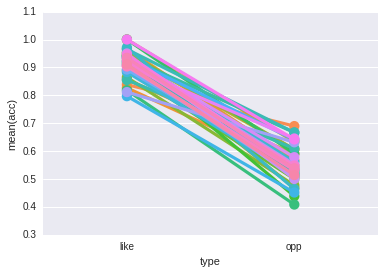

In [115]:
ax = sns.pointplot(x = 'type', y = 'acc', hue='config', data = accs)

ax.legend_.remove()

1. Worth doing continuous? (we care for e.g. encoder-decoder, also translating neuralese)
2. How to generalize to a statement about learning vs. just performance on this game?

3. Idea of "learning shapeworld captions", since in shapeworld you can generate
4. More distractors